# Trial Summary 

Data preparation:
- Filter genes with less than 10 non-zero expressions spots

Model:
- Nueral Matrix Factorization

Results:
- Train RMSE: 3.36
- Valid RMSE: 3.70
- Test RMSE: 3.70

# Imports

In [11]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import trainer_nmf as trainer
import data_nmf as get_data
from models import get_model
import tester_nmf as tester
from loss import *
from results_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Load Data 

In [3]:
min_counts = 500
min_cells = 177
apply_log = False
batch_size = 128

In [4]:
dl_train, dl_valid, dl_test, _ = get_data.main(
    min_counts=min_counts,
    min_cells=min_cells,
    apply_log=apply_log, 
    batch_size=batch_size, 
    device=device
)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285
New shape after filtering: (1185, 6279)
Data shape: (7440615, 3)
Number of genes: 6279
Number of spots: 1185
Train shape:(7440615, 3)
Valid shape:(383754, 3)
Test shape:(426393, 3)
Start creating the DataSets
Start creating the DataLoaders
Finish loading the data


# Modelling

## Set HyperParameters

In [5]:
model_name = 'NMF'
max_epochs = 150
early_stopping = 10
model_params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': batch_size
}

## Build Model 

In [6]:
model = get_model(model_name, model_params, dl_train)
optimizer = getattr(optim, model_params['optimizer'])(model.parameters(), lr=model_params['learning_rate'])
criterion = RMSELoss()

## Train Model 

In [7]:
model, valid_loss = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    early_stopping=early_stopping,
    dl_train=dl_train,
    dl_test=dl_valid, 
    device=device,
    model_name=model_name
)

2022-09-27 12:28:51.850859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 12:28:52.000191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-27 12:28:52.000222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-27 12:28:52.029242: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-27 12:28:52.821847: W tensorflow/stream_executor/platform/de

Training Results - Epoch[1] Avg loss: 8.70
Validation Results - Epoch[1] Avg loss: 13.97
Training Results - Epoch[2] Avg loss: 7.59
Validation Results - Epoch[2] Avg loss: 12.81
Training Results - Epoch[3] Avg loss: 5.59
Validation Results - Epoch[3] Avg loss: 9.17
Training Results - Epoch[4] Avg loss: 4.87
Validation Results - Epoch[4] Avg loss: 7.22
Training Results - Epoch[5] Avg loss: 4.40
Validation Results - Epoch[5] Avg loss: 6.09
Training Results - Epoch[6] Avg loss: 4.05
Validation Results - Epoch[6] Avg loss: 5.17
Training Results - Epoch[7] Avg loss: 3.93
Validation Results - Epoch[7] Avg loss: 4.86
Training Results - Epoch[8] Avg loss: 3.86
Validation Results - Epoch[8] Avg loss: 4.65
Training Results - Epoch[9] Avg loss: 3.77
Validation Results - Epoch[9] Avg loss: 4.39
Training Results - Epoch[10] Avg loss: 3.59
Validation Results - Epoch[10] Avg loss: 4.02
Training Results - Epoch[11] Avg loss: 3.45
Validation Results - Epoch[11] Avg loss: 3.76
Training Results - Epoch[1

2022-09-27 14:40:27,008 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[24] Avg loss: 3.70


In [ ]:
model

## Test 

In [9]:
test_loss, df_test_preds = tester.test(
    model=model,
    criterion=criterion,
    dl_test=dl_test,
    device=device
)
print(f'Test loss = {test_loss}')

Test loss = 3.7016085015423967


# Results Analysis 

In [10]:
df_test_preds['y_fixed'] = np.exp(df_test_preds['y'])
df_test_preds['y_pred_fixed'] = np.exp(df_test_preds['y_pred'])

y_col = 'y'
y_pred_col = 'y_pred'

df_test_preds['error'] = df_test_preds[y_col] - df_test_preds[y_pred_col]
df_test_preds.head()

,gene,spot,y,y_pred,y_fixed,y_pred_fixed,error
0,3616,398,2.0,1.431827,7.389056,4.186339,0.568173
1,525,892,5.0,4.252080,148.413159,70.251414,0.747920
2,1163,627,1.0,1.583250,2.718282,4.870760,-0.583250
3,1179,584,1.0,0.167508,2.718282,1.182354,0.832492
4,2670,162,3.0,1.431235,20.085537,4.183862,1.568765


## Errors Distribution 

count    426393.000000
mean          1.184312
std           5.949039
min         -97.634033
25%           0.070497
50%           0.711687
75%           1.604807
max         710.058319
Name: error, dtype: float64


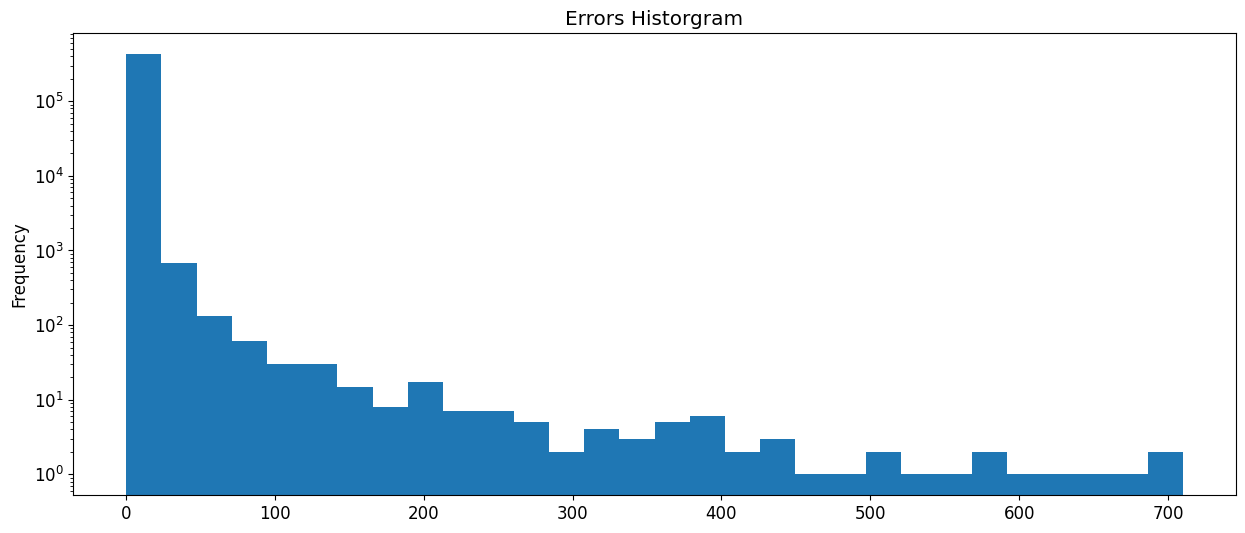

In [12]:
error_distribution(df_test_preds)

## Spots Errors Distribution 

In [14]:
spots_error_distribution(df_test_preds)

count    1185.000000
mean        1.162715
std         0.492027
min         0.188720
25%         0.897909
50%         1.080048
75%         1.318893
max         5.662536
Name: error, dtype: float64


## Genes Errors Distribution 

In [15]:
genes_error_distribution(df_test_preds)

count    6279.000000
mean        1.046319
std         2.261767
min        -0.427010
25%         0.727440
50%         0.863820
75%         1.024416
max       137.366875
Name: error, dtype: float64


## Errors Heat Map 

(1185, 6279)


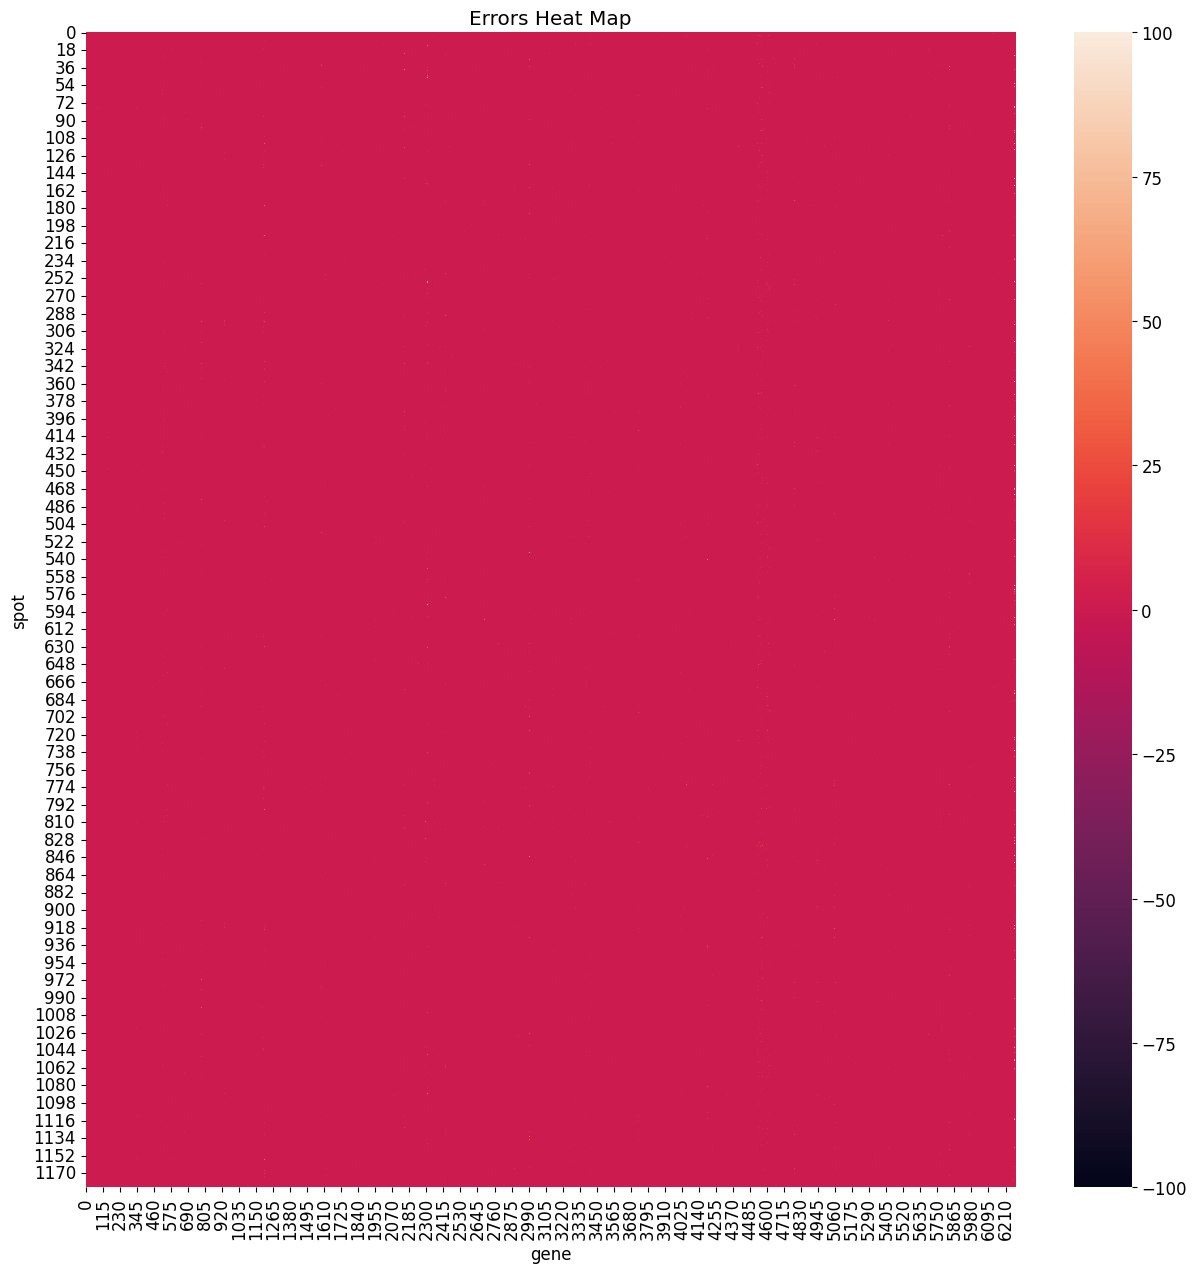

In [18]:
error_heat_map(df_test_preds, vmin=-100, vmax=100)